#               Epilepsy Detection using EEG Brain Signals

This code is related to the following section of [the paper](https://arxiv.org/abs/2403.17181):

## Section VII: Applications
### B. Epilepsy Detection using EEG Brain Signals

The section facilitates epilepsy detection using EEG brain signals, where the power spectral density (PSD) of the EEG signal is analyzed to extract features indicative of epilepsy.

For more details please refer to [the paper](https://arxiv.org/abs/2403.17181).

In [1]:
from scipy.io import loadmat
from numpy import asarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.matlib
from scipy import signal
from scipy.signal import welch
from scipy.stats import entropy
from scipy.fft import fft, fftfreq
import os
import glob
from warnings import warn
from sklearn import metrics
plt.rc('font',family='Times New Roman')
import warnings 
warnings.filterwarnings('ignore')


In [2]:
# Function to compute FFT:
def apply_fft(x, fs):
    N = len(x) # number of samples in the signal.
    T = 1.0 / fs
    fft_coef = fft(x-np.mean(x)) # Obtain FFT coefficients after removing the mean (DC component) from the signal.
    xf = fftfreq(N, T)[:N//2] # Taking positive spectrum only.
    fft_positve = 2.0/N * np.abs(fft_coef[0:N//2]) # Multiply  abs(FFT coefficients) by 2 to compensate for positive spectrum and normalize by signal length.
    return xf, fft_positve

In [3]:
def make_dataset(data_src):
    files = glob.glob(data_src)
    dataset_df = []
    for file in files:
        dataset_df.append(pd.read_csv(file, header = None))
    dataset = pd.concat(dataset_df, ignore_index=True, axis= 1)
    return dataset.T

In [4]:
# Function to compute PSD

def compute_psd(signal, length, fs):
    seg_length =  length/2 # Segment length.
    overlap = seg_length/3 # overlap between segements (in number of samples)
    nfft_length = 1024 # # FFT length
    frequencies, psd = welch(signal,  fs = fs, window='hann', nperseg= seg_length, noverlap= overlap, nfft= nfft_length)
    
    return frequencies, psd

In [5]:

def spectral_features(signal, fs):
    # Calculate the Power Spectral Density (PSD) using Welch's method
    
    L = len(signal)
    
    frequencies, psd = compute_psd(signal, L,  fs)

    # Normalize the PSD to compute the spectral features correctly
    psd_norm = psd / np.sum(psd)

    # Calculate the Spectral Centroid
    spectral_centroid = np.sum(frequencies * psd_norm)

    # Calculate the Spectral Spread (second central moment)
    spectral_spread = np.sqrt(np.sum(((frequencies - spectral_centroid) ** 2) * psd_norm))
   

    # Calculate the Spectral Entropy
    spectral_entropy = entropy(psd)
    
    peak_freq = frequencies[np.argmax(psd)] # peak freq.
    
    peak_pwr = np.max(psd) # Peak amp.
    

    return spectral_centroid, spectral_spread, spectral_entropy, peak_freq, peak_pwr

==========================================================================================================================
# Dataset Creatioin:
=========================================================================================================================== 

## Grouping vibration signals in required folders to  generate the dataset
 
Link to download the University of Bonn (UoB) EEG dataset dataset: https://www.ukbonn.de/epileptologie/arbeitsgruppen/ag-lehnertz-neurophysik/downloads/ <br>
The EEG signals are grouped according to their operational conditions in 5 folders (A-E): 

A ===>	Z.zip 	
B ===> 	O.zip	
C ===>	N.zip 	
D ===>	F.zip  	
E ===>	S.zip 	

In [6]:
data_path = (r"D:\Coding\Datasets\TUH_EEG_dataset\data\bonn_uni_datasets") # path to the 4 folders.
A  = make_dataset(os.path.join(data_path,  'A/*'))
B  = make_dataset(os.path.join(data_path,  'B/*'))
C  = make_dataset(os.path.join(data_path,  'C/*'))
D  = make_dataset(os.path.join(data_path,  'D/*'))
E  = make_dataset(os.path.join(data_path,  'E/*'))

In [7]:
normal = A.append(B).reset_index(drop = True).to_numpy()
interictal = C.append(D).reset_index(drop = True).to_numpy()
ictal = E.to_numpy()

In [8]:
num_samples =500 # Length of input segment
###########################################
fs =  173.61; # Sampling freq.

In [9]:
# Segmenting EEG signals:

data = normal.reshape(-1)
num_segments = np.floor(len(data)/num_samples)
slices = np.split(data[0:int(num_segments*num_samples)], num_samples)
normal = np.array(slices).reshape(int(num_segments), num_samples)
data = interictal.reshape(-1)
num_segments = np.floor(len(data)/num_samples)
slices = np.split(data[0:int(num_segments*num_samples)], num_samples)
interictal = np.array(slices).reshape(int(num_segments), num_samples)
data = ictal.reshape(-1)
num_segments = np.floor(len(data)/num_samples)
slices = np.split(data[0:int(num_segments*num_samples)], num_samples)
ictal = np.array(slices).reshape(int(num_segments), num_samples)

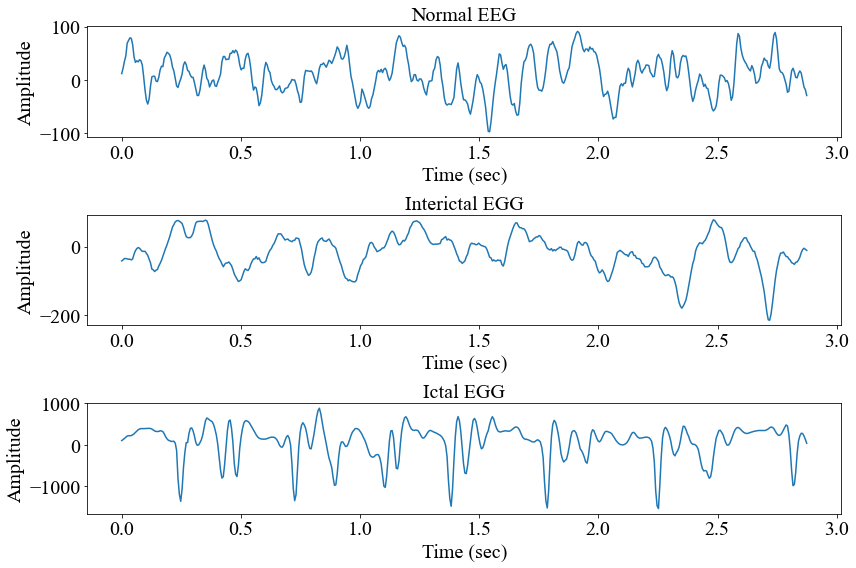

In [10]:
# Sample EEG signals representing the three classes of the UoB dataset.

index = 0

normal_EEG = normal[index]
interictal_EGG = interictal[index]
ictal_EGG = ictal[index]
time = np.arange(0.0, len(normal_EEG), 1.0)/fs
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.tick_params('x', labelsize=20)
plt.tick_params('y', labelsize=20)
plt.plot(time, normal_EEG)
plt.xlabel('Time (sec)', fontsize = 20)
plt.ylabel('Amplitude', fontsize = 20)
plt.title("Normal EEG", fontsize = 20)
plt.subplot(3, 1, 2)
plt.tick_params('x', labelsize=20)
plt.tick_params('y', labelsize=20)
plt.plot(time, interictal_EGG)
plt.xlabel('Time (sec)', fontsize = 20)
plt.ylabel('Amplitude', fontsize = 20)
plt.title("Interictal EGG", fontsize = 20)
plt.subplot(3, 1, 3)
plt.tick_params('x', labelsize=20)
plt.tick_params('y', labelsize=20)
plt.plot(time, ictal_EGG)
plt.xlabel('Time (sec)', fontsize =20)
plt.ylabel('Amplitude', fontsize = 20)
plt.title("Ictal EGG", fontsize = 20)
plt.tight_layout()
plt.show()

In [11]:
normal_labels = np.zeros(len(normal))
interictal_labels = np.ones(len(interictal))
ictal_labels = np.ones(len(ictal))*2
X = np.concatenate( (normal, interictal, ictal) , axis=0, out=None)
Y = np.concatenate( (normal_labels, interictal_labels, ictal_labels ) , axis=0, out=None)
print("data set features size:", X.shape)
print("data set labels size:", Y.shape)
print(X.shape)

data set features size: (4095, 500)
data set labels size: (4095,)
(4095, 500)


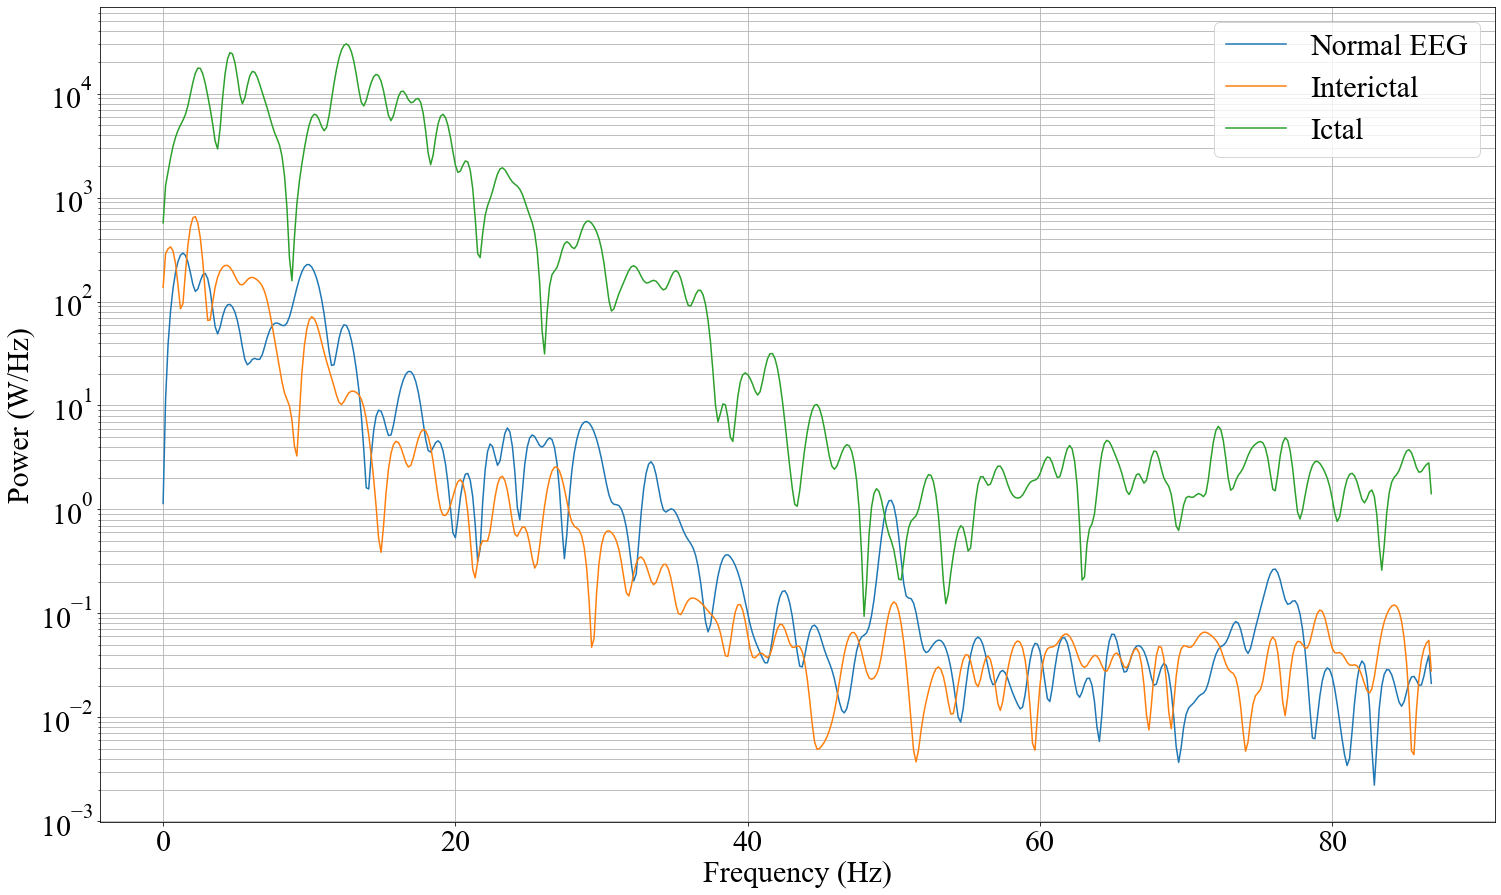

In [12]:
# Samples of estimated PSDs representing the three classes of the UoB dataset.

f1, psd1 = compute_psd(normal[index], len(normal[index]),  fs)
f2, psd2 = compute_psd(interictal[index],len(interictal[index]),   fs)
f3, psd3 = compute_psd(ictal[index],len(interictal[index]),   fs)


plt.figure(figsize=(25, 15))
plt.grid(True, which ="both")
plt.semilogy(f1, psd1, label = 'Normal EEG')
plt.semilogy(f2, psd2, label = 'Interictal')
plt.semilogy(f3, psd3, label = 'Ictal')

plt.xlabel('Frequency (Hz)', fontsize = 30)
plt.ylabel('Power (W/Hz)', fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize= 30)
plt.legend(fontsize=30)
plt.show()

In [13]:
# Design of  a band-pass filter with pass and cut-off frequencies of 0.5 HZ and 30 Hz:

from scipy.signal import butter, filtfilt

N = 4  # Filter order. Generally, a higher order will have a steeper roll-off

# Butterworth band-pass filter design
b, a = butter(N, [0.5, 30],fs =fs,  btype='band', analog=False) # a & b are filter coefficients

In [14]:
# Filtering:
signal = X[0]

# Apply the filter to the signal
filtered_signal = filtfilt(b, a, signal)

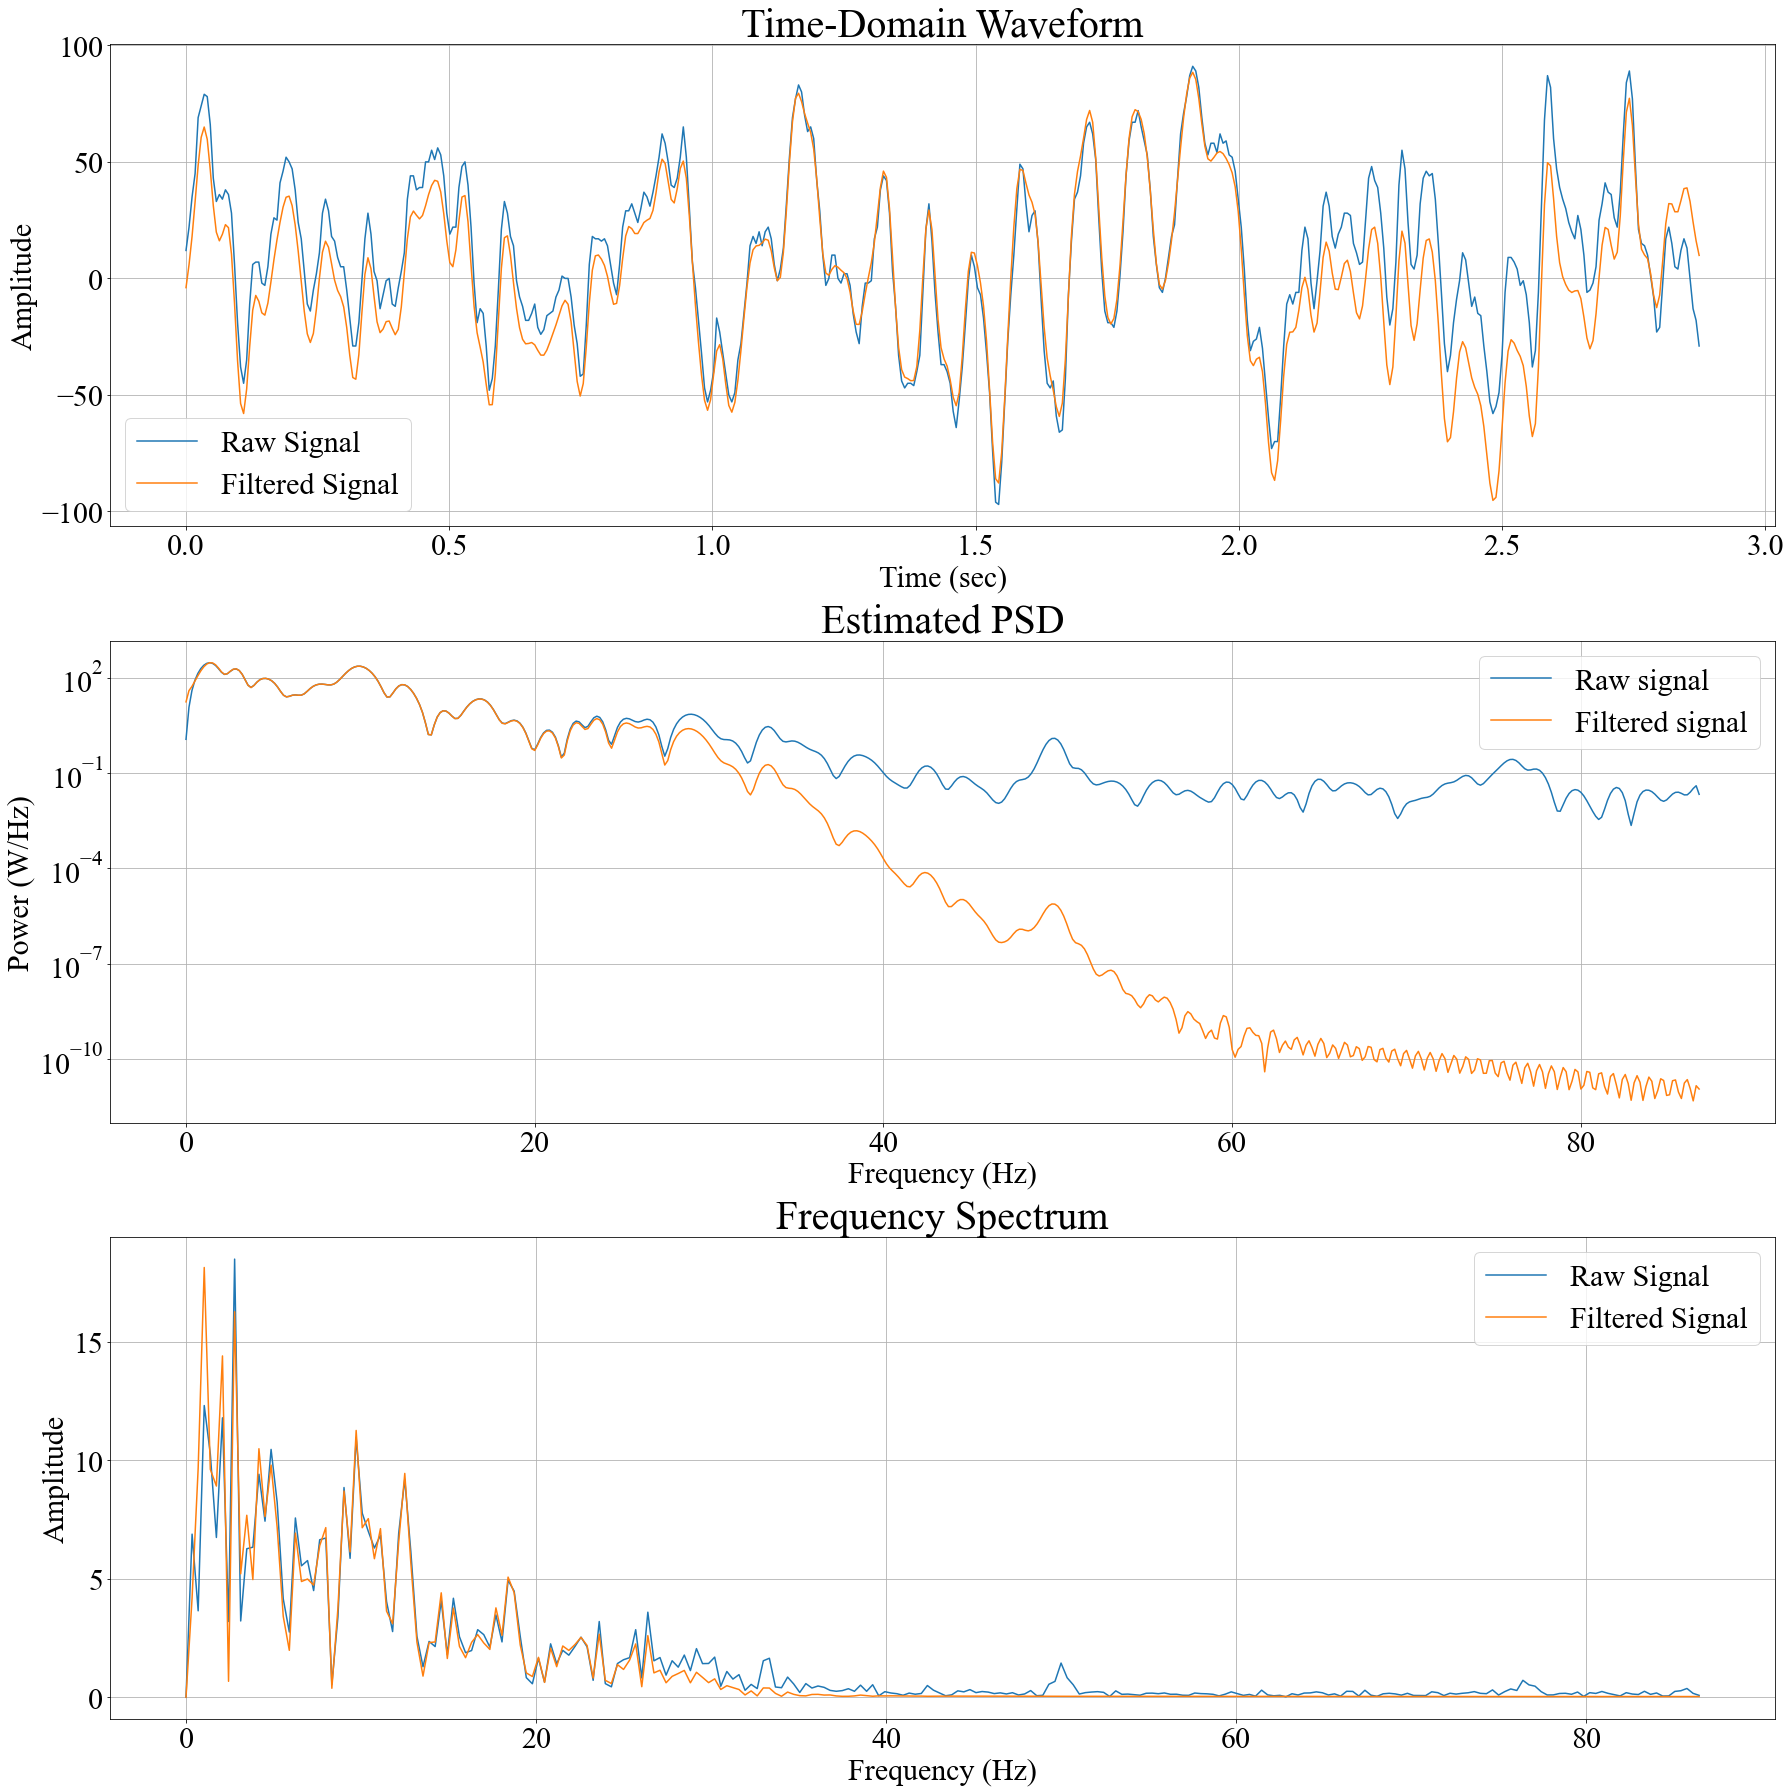

In [15]:
# A comparison between unfiltered (raw) and filtered EEG signals.

time = np.arange(0.0, len(signal), 1.0)/fs

f1, psd1 = compute_psd(signal, len(signal), fs)
f2, psd2 = compute_psd(filtered_signal,len(filtered_signal),  fs)

f_raw, x_raw = apply_fft(signal, fs)
f_lp, x_lp = apply_fft(filtered_signal, fs)

plt.figure(figsize=(25, 25))
plt.subplot(3, 1, 1)
plt.tick_params('x', labelsize=30)
plt.tick_params('y', labelsize=30)
plt.plot(time, signal, label='Raw Signal')
plt.plot(time, filtered_signal, label='Filtered Signal')
plt.xlabel('Time (sec)', fontsize = 30)
plt.ylabel('Amplitude', fontsize = 30)
plt.tick_params('x', labelsize=30)
plt.tick_params('y', labelsize=30)
plt.title('Time-Domain Waveform', fontsize = 40)
plt.legend(fontsize=30)
plt.grid(True)


plt.subplot(3, 1, 2)
plt.semilogy(f1, psd1, label = 'Raw signal')
plt.semilogy(f2, psd2, label = 'Filtered signal')
plt.xlabel('Frequency (Hz)', fontsize = 30)
plt.ylabel('Power (W/Hz)', fontsize = 30)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize= 30)
plt.title('Estimated PSD', fontsize = 40)
plt.legend(fontsize=30)
plt.grid(True)


plt.subplot(3, 1, 3)
plt.plot(f_raw, x_raw, label='Raw Signal')
plt.plot(f_lp, x_lp, label='Filtered Signal')
plt.xlabel('Frequency (Hz)', fontsize = 30)
plt.ylabel('Amplitude', fontsize = 30)
plt.tick_params('x', labelsize=30)
plt.tick_params('y', labelsize=30)
plt.title('Frequency Spectrum', fontsize = 40)
plt.legend(fontsize=30)
plt.grid(True)

plt.tight_layout()
plt.show()


In [16]:
# Feature calculations

num_signals = len(X)
num_features = 5
feature_matrix = np.zeros((num_signals, num_features))  # Initialize a matrix to store the features

# Loop over 10 signals
for i in range(num_signals):
    sig_in = filtfilt(b, a, X[i])
    #sig_in =X[i]
    spectral_centroid, spectral_spread, spectral_entropy, peak_freq, peak_pwr = spectral_features(sig_in, fs)
    
    # Store the features in the matrix
    feature_matrix[i, :] = [spectral_centroid, spectral_spread, spectral_entropy, peak_freq, peak_pwr]
    
print(feature_matrix.shape)

(4095, 5)


In [17]:
from skopt import Optimizer
from skopt import BayesSearchCV 
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [18]:
labels = Y

In [19]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, labels, test_size = 0.3, 
                                                    shuffle = True, stratify = labels, random_state = 42)

In [20]:
X_train.shape

(2866, 5)

In [21]:
X_test.shape

(1229, 5)

In [22]:
scaler =MinMaxScaler()
train_data_scaled = scaler.fit_transform(X_train)
test_data_scaled = scaler.transform(X_test)

In [23]:
clf_RF = RandomForestClassifier(criterion='entropy', max_features = 1, min_samples_leaf=1, min_samples_split=2, 
                                max_depth=200, n_estimators=1000, random_state= 42)
best_clf = clf_RF.fit(train_data_scaled, y_train)

ROC AUC = 0.991
F1 Score = 0.9454841334418226
Accuracy = 94.548 %


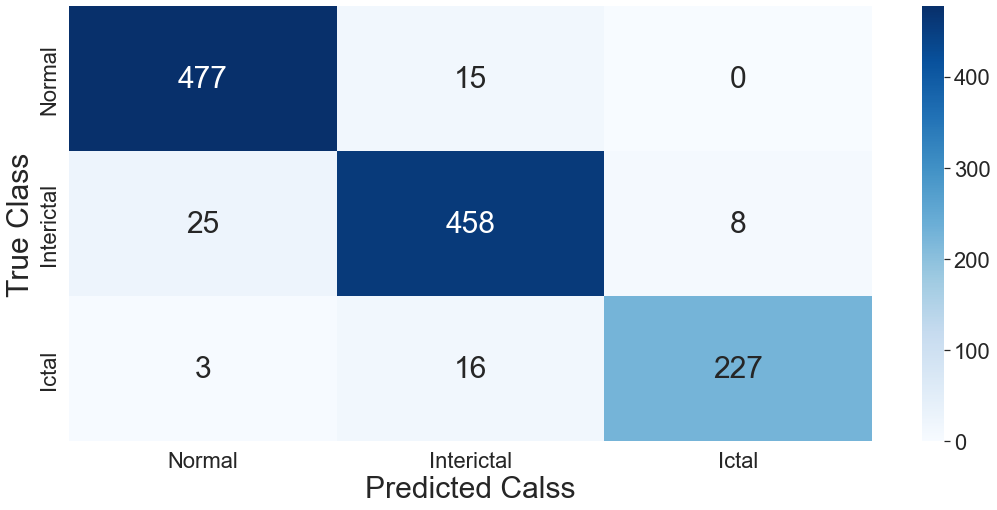

In [24]:
test_predictions = best_clf.predict(test_data_scaled)
test_confu_matrix = confusion_matrix(y_test, test_predictions)
fault_type = ['Normal','Interictal','Ictal']
plt.figure(1,figsize=(18,8))
sns.set(font_scale=2)
sns.heatmap(test_confu_matrix, annot= True,fmt = "d",
xticklabels=fault_type, yticklabels=fault_type, cmap = "Blues", annot_kws={"size": 30})
plt.xlabel('Predicted Calss', fontsize = 30)
plt.ylabel('True Class', fontsize = 30)
Accuracy = metrics.accuracy_score(y_test, test_predictions)
F1_score = metrics.f1_score(y_test, test_predictions, average='micro')
probs = best_clf.predict_proba(test_data_scaled)
lr_auc = roc_auc_score(y_test, probs, multi_class='ovr')
print('ROC AUC = %.3f' % (lr_auc))
print("F1 Score =", F1_score)
print("Accuracy = %.3f" % (Accuracy*100), "%")